# Resonant depolarization

In [1]:
%matplotlib widget

In [2]:
import xtrack as xt
import xpart as xp
import xobjects as xo
import numpy as np
import matplotlib.pyplot as plt

### Load and configure ring model

In [3]:
line = xt.Line.from_json('lattice/lep_sol.json')
line.particle_ref.anomalous_magnetic_moment=0.00115965218128
line.particle_ref.gamma0 = 89207.78287659843 # to have a spin tune of 103.45
spin_tune = line.particle_ref.anomalous_magnetic_moment[0]*line.particle_ref.gamma0[0]

Loading line from dict:   0%|          | 0/9667 [00:00<?, ?it/s]

Done loading line from dict.           


In [4]:
# RF
line['vrfc231'] = 12.65  # qs=0.6 with radiation

In [5]:
# Match tunes to those used during polarization measurements
# https://cds.cern.ch/record/282605
opt = line.match(
    method='4d',
    solve=False,
    vary=xt.VaryList(['kqf', 'kqd'], step=1e-4),
    targets=xt.TargetSet(qx=65.10, qy=71.20, tol=1e-4)
)
opt.solve()

                                             
Optimize - start penalty: 2.635                             
Matching: model call n. 9 penalty = 4.9258e-05              
Optimize - end penalty:  4.92578e-05                            


### No solenoid, no spin bumps

In [6]:
line['on_solenoids'] = 0
line['on_spin_bumps'] = 0
line['on_coupling_corrections'] = 0

In [7]:
tw = line.twiss(spin=True)

In [8]:
from chirp_kicker import VerticalChirpKicker
kicker = VerticalChirpKicker(
    k0sl=0,
    q_start=0,
    q_end=0,
    num_turns=0,
)
line.insert('spin_kicker', obj=kicker, at='bfkv1.qs18.r2@start')

Slicing line:   0%|          | 0/9550 [00:00<?, ?it/s]

In [9]:
line.configure_spin('auto')

In [10]:
dq_sweep = 0.003

q_start_tests = np.linspace(0.425, 0.455, 5)[1:]

q_start_tests = [0.44, 0.448, 0.453]

f_list = []
spin_list = []

for iii, qqq in enumerate(q_start_tests):
    num_turns = 15000
    q_start_excitation = qqq
    q_end_excitation = q_start_excitation + dq_sweep
    k0sl_peak = 5e-6

    kicker.k0sl = k0sl_peak
    kicker.q_start = q_start_excitation
    kicker.q_end = q_end_excitation
    kicker.num_turns = num_turns

    p = tw.particle_on_co.copy()

    line.track(p, num_turns=num_turns, turn_by_turn_monitor=True,
            with_progress=1000)
    mon = line.record_last_track

    freq_axis = np.linspace(q_start_excitation, q_end_excitation, num_turns)
    f_list.append(freq_axis)
    spin_list.append(mon.spin_y[0, :])


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/15000 [00:00<?, ?it/s]

Tracking:   0%|          | 0/15000 [00:00<?, ?it/s]

Tracking:   0%|          | 0/15000 [00:00<?, ?it/s]

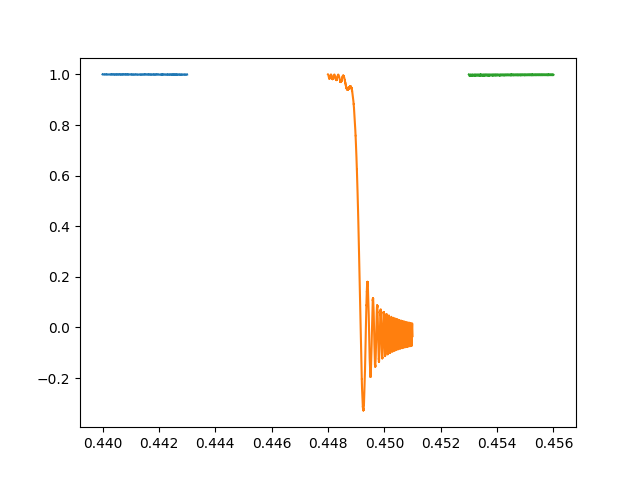

In [11]:
plt.figure()
plt.plot(f_list[0], spin_list[0])
plt.plot(f_list[1], spin_list[1])
plt.plot(f_list[2], spin_list[2])